In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score, roc_auc_score
import mlflow
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
from torch.autograd import Variable

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = ('/content/drive/MyDrive/Datasets/Screw Dataset/archive/train')
test_dir = ('/content/drive/MyDrive/Datasets/Screw Dataset/archive/test')

train_dataset = ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
class_names = test_dataset.classes
print(class_names)

['good', 'not-good']


In [10]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
# Instantiate Autoencoder and send to GPU
autoencoder = Autoencoder().to(device)

# Definition of loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [12]:
# training
for epoch in range(100):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_loader)))

# test
autoencoder.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = Variable(img).to(device)
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        test_loss += loss.item()

print('Test Loss: %.4f' % (test_loss/len(test_loader)))

Epoch [1], Loss: 1.9253
Epoch [2], Loss: 1.9255
Epoch [3], Loss: 1.9262
Epoch [4], Loss: 1.9262
Epoch [5], Loss: 1.9300
Epoch [6], Loss: 1.9287
Epoch [7], Loss: 1.9281
Epoch [8], Loss: 1.9277
Epoch [9], Loss: 1.9283
Epoch [10], Loss: 1.9268
Epoch [11], Loss: 1.9256
Epoch [12], Loss: 1.9291
Epoch [13], Loss: 1.9292
Epoch [14], Loss: 1.9272
Epoch [15], Loss: 1.9255
Epoch [16], Loss: 1.9265
Epoch [17], Loss: 1.9294
Epoch [18], Loss: 1.9279
Epoch [19], Loss: 1.9280
Epoch [20], Loss: 1.9263
Epoch [21], Loss: 1.9294
Epoch [22], Loss: 1.9275
Epoch [23], Loss: 1.9265
Epoch [24], Loss: 1.9285
Epoch [25], Loss: 1.9314
Epoch [26], Loss: 1.9262
Epoch [27], Loss: 1.9289
Epoch [28], Loss: 1.9284
Epoch [29], Loss: 1.9253
Epoch [30], Loss: 1.9250
Epoch [31], Loss: 1.9241
Epoch [32], Loss: 1.9263
Epoch [33], Loss: 1.9275
Epoch [34], Loss: 1.9230
Epoch [35], Loss: 1.9277
Epoch [36], Loss: 1.9236
Epoch [37], Loss: 1.9233
Epoch [38], Loss: 1.9298
Epoch [39], Loss: 1.9290
Epoch [40], Loss: 1.9311
Epoch [41

In [13]:
#### comparison bertween classes in test data
autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

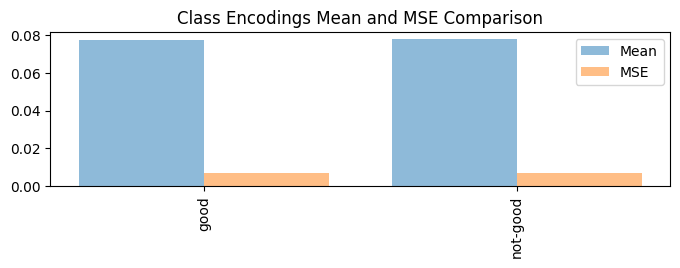

In [15]:
class_means = []
class_mses = []
for i in range(2):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8, 2))
plt.bar(np.arange(2)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(2)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(2), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()